In [1]:
import numpy as np
from PIL import Image

# Built-in modules
import os
import json
import datetime as dt
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Visualisation utilities from utils.py
import sys
sys.path.append('./ai4eo/')
from ai4eo.utils import get_extent, md5_encode_files

In [2]:
tiffdir = '/work/ka1176/caroline/gitlab/ai4eo-challenge/ai4eo/submission_random_2_TV/'

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import os
from sklearn.metrics import matthews_corrcoef

In [4]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
valid_patches = ['processed_eopatch-850', 'processed_eopatch-818', 'processed_eopatch-498', 'processed_eopatch-815', 
                 'processed_eopatch-738', 'processed_eopatch-877', 'processed_eopatch-870', 'processed_eopatch-894', 
                 'processed_eopatch-558', 'processed_eopatch-363']

Red: False positive (predicted cultivated land where there was none)
Blue: False negative (failed to predict cultivated land)

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


850 0.957745231227542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


818 0.940971218462391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


498 0.9661499460491272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


815 0.8226876969870499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


738 0.8885723879492332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


877 0.9574235724114524


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


870 0.7357868268089317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


894 0.9571277745203459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


558 0.9599441801480376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


363 0.9752403317572254


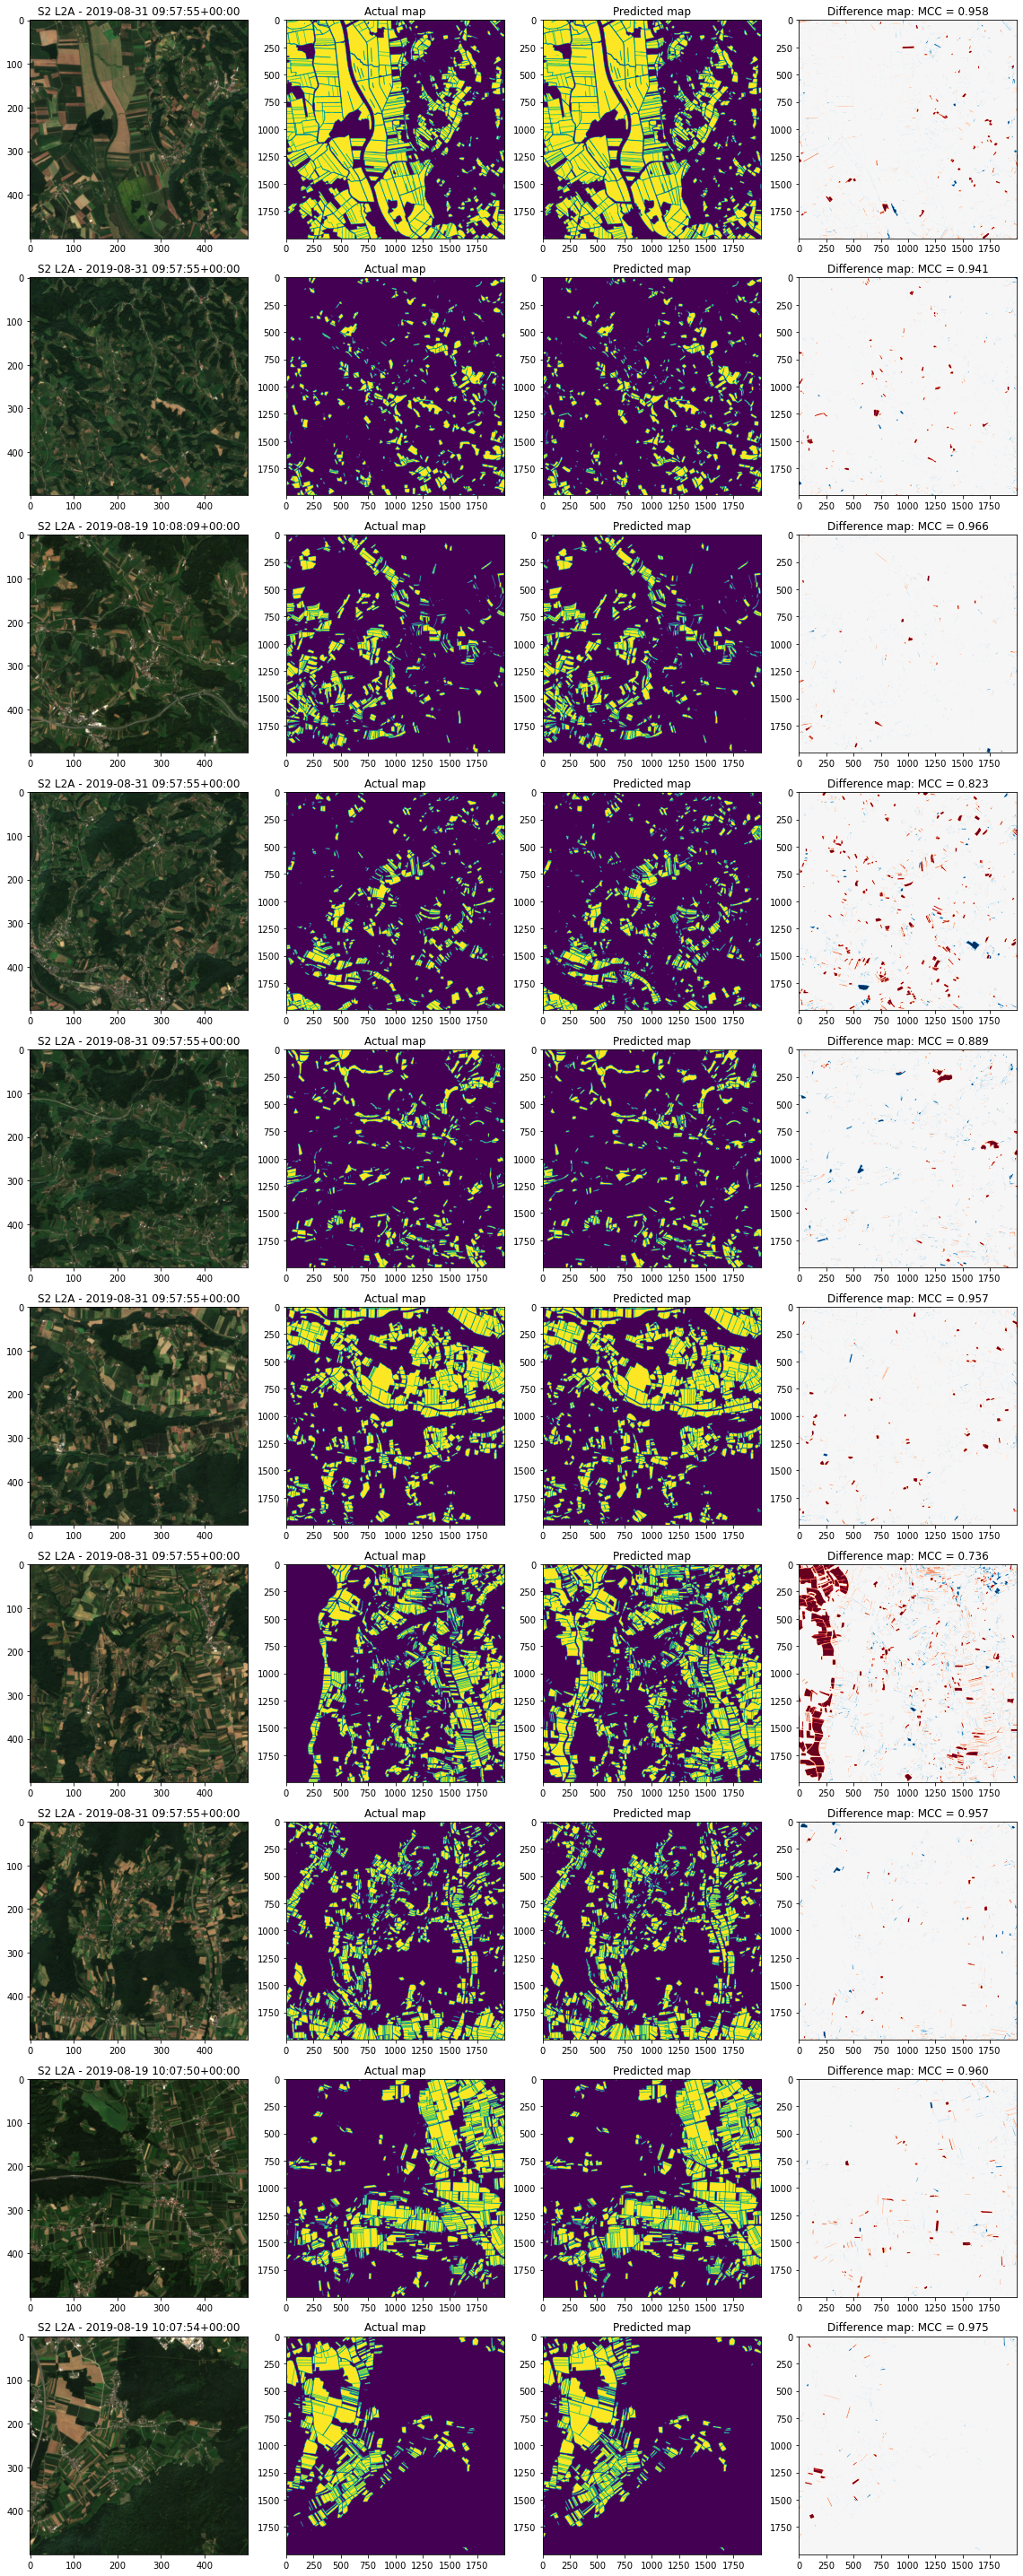

In [15]:
path = '/work/ka1176/shared_data/2021-ai4eo/eopatches/train/'

fig, axs = plt.subplots(figsize=(16, 40), nrows=10, ncols=4)

for i, patch_ix in enumerate([850, 818, 498, 815, 738, 877, 870, 894, 558, 363]):
    eopatch = EOPatch.load(os.path.join(path, f'eopatch-{patch_ix:02d}'))
    
    vis_factor = 3.5

    norm_factor = eopatch.scalar['NORM_FACTORS'][0]

    
    valid_data = np.mean(eopatch.mask['IS_DATA'] & ~eopatch.mask['CLM'], axis=(1,2,3))
    tidx = np.where(valid_data>0.99)[0][-1]
    
    axs[i,0].imshow(vis_factor * norm_factor * eopatch.data['BANDS'][tidx][..., [3, 2, 1]])
    axs[i,0].set_title(f'S2 L2A - {eopatch.timestamp[tidx]}')
    
    try:
        img = Image.open(os.path.join(tiffdir, f'eopatch-{patch_ix:02d}.tif'))
        x_img = np.array(img)
    except:
        continue

    y = eopatch.mask_timeless['CULTIVATED'].squeeze()
    z = x_img.astype(int) - y.astype(int)
    
    mcc = matthews_corrcoef(y.flatten(), x_img.flatten())
    print(patch_ix, mcc)


    axs[i,1].imshow(y)
    axs[i,1].set_title('Actual map')

    axs[i,2].imshow(x_img)
    axs[i,2].set_title('Predicted map')

    axs[i,3].imshow(z, cmap='RdBu_r')
    axs[i,3].set_title(f'Difference map: MCC = {mcc:.3f}')

fig.tight_layout()

In [ ]:
plt.imshow(eopatch.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(eopatch), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11)